# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [1]:
"""

"""
# %matplotlib inline
%matplotlib notebook


from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 
from matplotlib import colorbar as mpl_colorbar
from matplotlib import rc
rc('text', usetex=True)

import os
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

from multiprocessing import Pool, cpu_count
from contextlib import closing

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [2]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
# opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/Fake_Rolling/Rolling_3_80/Rolling_3_80.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

In [3]:
opsimdf.head()

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,61,1016,53,297,2.208152,-1.096113,y,5308,59580.061443,0,...,0.0,121.983579,0.799369,0.0,0.0,0.909616,69.236916,21.084922,2.174738,-1.122564
1,62,1016,53,180,2.437102,-1.195036,y,5349,59580.061915,0,...,0.0,132.407937,0.799369,0.0,0.0,0.136237,6.788134,20.951019,2.395487,-1.221487
2,63,1016,53,140,2.513274,-1.238016,y,5387,59580.062359,0,...,0.0,134.805912,0.799369,0.0,0.0,0.050425,4.325363,20.919163,2.466524,-1.264467
3,64,1016,53,108,2.611135,-1.279219,y,5426,59580.062802,0,...,0.0,137.524490,0.799369,0.0,0.0,0.050956,4.319809,20.882435,2.558008,-1.305670
4,65,1016,53,83,2.739507,-1.318007,y,5464,59580.063246,0,...,0.0,140.538643,0.799369,0.0,0.0,0.051847,4.320722,20.840852,2.678445,-1.344458


In [4]:
len(opsimdf["fieldID"].unique())

3339

In [5]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)

Add extinction to the dataframe

In [6]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

<IPython.core.display.Javascript object>


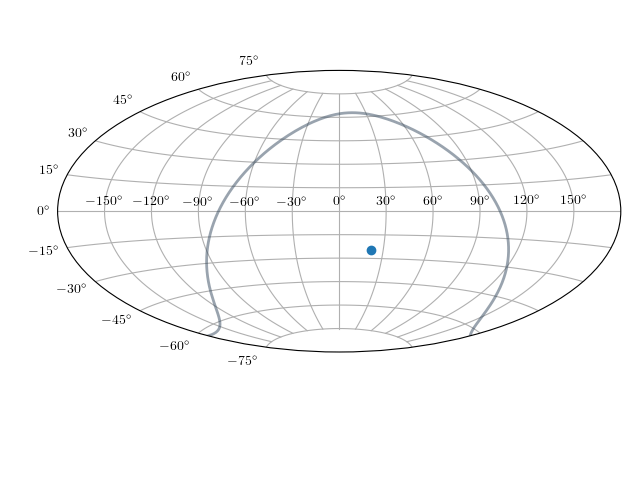

/Users/berto/Code/LSST_tools/lsst_tools


In [7]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [8]:
working_df = opsimdf

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [9]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
working_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [10]:
working_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,297,2.208152,-1.096113,2.238695,2.177609,-1.126656,-1.065570
1,180,2.437102,-1.195036,2.467645,2.406559,-1.225579,-1.164493
2,140,2.513274,-1.238016,2.543817,2.482731,-1.268559,-1.207473
3,108,2.611135,-1.279219,2.641678,2.580592,-1.309762,-1.248676
4,83,2.739507,-1.318007,2.770050,2.708964,-1.348550,-1.287464
5,69,2.911089,-1.353247,2.941632,2.880546,-1.383790,-1.322704
6,40,2.847358,-1.399747,2.877901,2.816815,-1.430290,-1.369204
7,61,2.649662,-1.362522,2.680205,2.619119,-1.393065,-1.331979
8,78,2.513274,-1.321947,2.543817,2.482731,-1.352490,-1.291404
9,112,2.415415,-1.279218,2.445958,2.384872,-1.309761,-1.248675


In [11]:
field_df = working_df[(working_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (working_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (working_df["Dec_lower"] >= df["phi"][0])  &
                (working_df["Dec_upper"] <= df["phi"][0])]

<IPython.core.display.Javascript object>


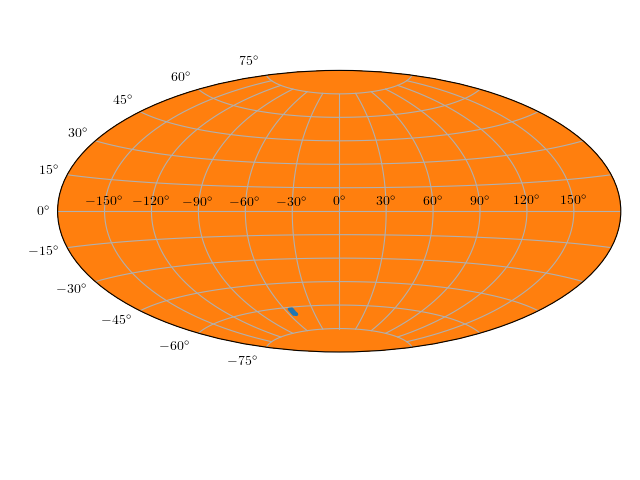

In [12]:
reload(utils)
utils.plot_field(working_df)

In [13]:
df = opsimdf

In [14]:
## Work out how often each field is visited
min_visits = df["fieldID"].value_counts().min()
max_visits = df["fieldID"].value_counts().max()

print(min_visits, ",",max_visits)

df['count'] = df.groupby('fieldID').cumcount()

180 , 22778


In [15]:
df["fieldID"].value_counts()

290     22778
2786    20393
1144     1136
460      1089
2182     1085
2314     1081
2434     1080
2206     1069
1470     1053
2466     1040
2356     1040
839      1020
1275     1016
1956     1007
2058     1005
1391     1003
2424     1002
2540     1002
2303     1001
2430     1000
2065     1000
1954     1000
1837      997
2216      997
2318      997
2200      996
2664      995
1976      995
2776      995
2087      994
        ...  
614       180
465       180
167       180
168       180
2217      180
362       180
169       180
170       180
2661      180
287       180
171       180
172       180
1735      180
173       180
174       180
1836      180
994       180
175       180
176       180
286       180
1304      180
177       180
178       180
3220      180
285       180
179       180
180       180
358       180
181       180
206       180
Name: fieldID, dtype: int64

In [16]:
# ddf = [1427,744,2412,290,2786]
ddf = [290,2786]

In [17]:
cmap = plt.get_cmap("viridis")

df["cmap_visit_value"] = np.log((df["count"] + 1)/(max_visits+1))

In [18]:
df["cmap_visit_value"] = df["cmap_visit_value"] + np.abs(df["cmap_visit_value"].min())
df["cmap_visit_value"] = df["cmap_visit_value"]/df["cmap_visit_value"].max()

In [19]:
df["fieldID"].value_counts().hist(bins = 200, range = [0, 2000])

In [20]:
df = utils.get_field_corners(df)

In [21]:
night_group = df.groupby("night")

In [22]:
# ddf_df = df.loc[df["fieldID"] == 2786]
# wfd_df = df.loc[df["fieldID"] == 1000]

# wfd_df.to_csv("wfd_opsimdf_fieldID1000_fakerolling.csv")
# ddf_df.to_csv("ddf_opsimdf_fieldID2786_fakerolling.csv")

In [ ]:
df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]

# outpath = "/Users/berto/plots/LSST/cadence/minion/Test_skymap_night_"
# outpath = os.path.join(os.environ["HOME"], "plots/LSST/cadence/Fake_Rolling/markersize/skymap_night_")
outpath = os.path.join(os.environ["HOME"], "plots/LSST/cadence/Fake_Rolling/LSSTUK/skymap_night_")

df_to_plot["zorder"] = df_to_plot["fieldID"]*0
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99
norm = mpl_colors.LogNorm(vmin=max_visits, vmax=min_visits)
markersize = 15.

# for i, group in enumerate(np.arange(4)):
for i, group in enumerate(night_group.groups):

    if i == 0:
        fig = plt.figure()
        fig.subplots_adjust(left = 0.05, bottom = 0.05, top = 0.99,
                            right = 0.97, hspace=0, wspace = .1)
    
#         ax_aitoff = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#         ax_aitoff.grid(True)
#         ax_active = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#         ax_active.grid(True)
    
        ax_aitoff = fig.add_subplot(111, projection = "aitoff")
        ax_active = fig.add_subplot(111, projection = "aitoff")
        ax_aitoff.grid(True)
        ax_active.grid(True)
        ax_aitoff.set_xticklabels(['$2^h$','$4^h$','$6^h$', '$8^h$', '$10^h$', '$12^h$',
                                  '$14^h$','$16^h$','$18^h$','$20^h$','$22^h$'], fontsize=10)
        ax_active.set_xticklabels(['$2^h$','$4^h$','$6^h$', '$8^h$', '$10^h$', '$12^h$',
                                  '$14^h$','$16^h$','$18^h$','$20^h$','$22^h$'], fontsize=10)
#         ax_cbar = plt.subplot2grid((1,24), (0,22), colspan = 1, rowspan = 1)
        ax_cbar = fig.add_subplot(20,1,19)
        cb1 = mpl_colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm, orientation='horizontal')
        cb1.set_label(r'$\textnormal{Number of Visits}$')
        
        working_df_to_plot = df_to_plot.loc[night_group.groups[group]]

    else:
#         ax_active = fig.add_subplot(111, projection = "aitoff")
        working_df_to_plot = pd.concat([working_df_to_plot,df_to_plot.loc[night_group.groups[group]]])
    
        working_df_to_plot.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")
    
    s = r"$\textnormal{night} = " + str(i) + "$"
    txt = plt.figtext(0.85, 0.8, s)
        
    s1 = ax_aitoff.scatter(working_df_to_plot["fieldRA"] - np.pi, 
                      working_df_to_plot["fieldDec"], 
                      color = cmap(working_df_to_plot["cmap_visit_value"]),
                      s = markersize)

    
    s2 = ax_aitoff.scatter(working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]] - np.pi, 
                      working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldDec"]], 
                      color = cmap(working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"]),
                      s = markersize)
    
    s_a = ax_active.scatter(df_to_plot.loc[night_group.groups[group]]["fieldRA"] - np.pi, 
                      df_to_plot.loc[night_group.groups[group]]["fieldDec"], 
                      color = cmap(df_to_plot.loc[night_group.groups[group]]["cmap_visit_value"]),
                      edgecolor = colours.hex["black"],
                      s = markersize)


    plt.draw()
    fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)
    s_a.remove()
    txt.remove()